# Part and Parcel: *Predicting North American Freight Costs with Supervised Machine Learning*


### Capstone Project Final Report
*Kimberly Kaufman*  
*September 23, 2019*
  
---

### Abstract

Despite the continuous growth of ebooks over the past decade, the publishing industry continues to fulfill a significant demand for physical, printed books. The cost of distributing print books can vary structurally based on factors such as fixed vs variable, owned vs 3PL, and other differing permutations of distribution cost models. But one significant distribution cost that is relatively constant for all publishers is the cost of freight.

At Wiley, freight costs for North American outbound volume alone can cost millions annually in USD. Although the current methods used to model these costs have been sufficient for financial planning purposes, there is most certainly room for improvement. Previous forecasts have been derived from very basic time series modeling, but we have not yet attempted to apply machine learning to improve our accuracy.

This project aims to predict the freight cost of physical book fulfillment (on both an individual shipment level and an aggregate level) by using supervised machine learning methods on a year’s worth of supply chain data out of our North American distribution center. By implementing a more complex modeling approach, we hope to improve our forecasting accuracy as well as gain better visibility into the main drivers of our costs.

For more details on this project, see the <a href="https://github.com/kaufkauf/Capstone-Project-Intermediate">GitHub repository</a>.

### Data Set

All supporting data is proprietary and available through Wiley's internal systems. Since Wiley utilizes a 3PL provider for distribution, there are a few cost-related variables that do not interface directly to the main system. For these variables, the data has been scraped from the monthly billing emails and manually uploaded to the main system. The complete subset of data used for this analysis will then be extracted to a csv file via SQL query. Although the full dataset used cannot be shared here, the variables are listed below.
    
The attributes of the volume dataset include:
* 3 Product description variables
    + ISBN10, product line, global business (categorical; object)
* 13 Invoice level variables
    + Invoice date (IHINDT), 3PL interface date (CJDAT1), ship verify date (IHAEDT) (continuous; integer)
    + Invoice number (continuous; integer)
    + Batch number (categorical; object)
    + Carton quantity, cartons per pallet (continuous; integer)
    + Outbound units, outbound loose, outbound cartons, outbound pallets (continuous; integer)
    + Book weight (continuous; float)
* 2 Customer demographic variables
    + Market outlet, customer destination (categorical; object)
* 4 Transportion variables
    + Ship method, freight type, priority code, carrier code, collect y/n (categorical; object)
    
The attributes of the freight dataset include:
* 1 Product description variables
    + Product group (categorical)
* 5 Invoice level variables
    + Invoice date (INVDATE), 3PL interface date (INTDATE), billing date (BILLDATE) (continuous; integer)
    + Invoice number (INVNUMBER) (continuous; integer)
    + Shipment weight (continuous; float)
* 1 Output variable / target
    + Total charge (continuous; float)
      
      
Note that each dataset is read in as a Pandas data frame.  Our consolidated volume data frame contains 22 variables and 1,131,645 observations, whereas our freight data frame contains 7 variables and 129,822 observations.  These shapes are relatively normal for a couple of reasons: first, the freight charges have been rolled up to the invoice level whereas the volume information is at a line level detail; second, not all of our outbound volume incurs freight cost to Wiley. So, we would expect our volume data to have many more observations than our freight data.

### Data Cleaning / Wrangling

#### Approach
There are two pieces to our data wrangling:
1. Separately cleaning/munging the two datasets
2. Joining together the volume and freight datasets.  

#### Missing Values
We had three variables in our data with missing variables: freight type, ship country name, and product group.  We were able to fill in the missing freight type variables with some supplementary data from our supply chain team.  The missing ship country name variables were negligible in size and were replaced with "Unknown."  We did not clean any of the missing values in "product group" since this variable is not a useful piece of data to begin with, and is better represented by our "global business" variable anyway.

#### Outliers
Some outliers were found in our book weight variable that appeared to be too high to be realistic.  For example, book weight is measured in ounces, and there were observations found in which a book was listed as above 8,000 ounces, which does not fit the specs of any of our books.  We also found quite a few observations where the book weight was equal to zero, which is also not realistic for a physical book unit.  Therefore, a flooring/capping treatment was used on the book weight variable.  Any outliers on the low & high side were imputed with the 5th & 9th percentiles, respectively.

#### Data Frame Consolidation
After missing values and outlier treatments, volume data must be rolled up to an invoice level and then joined to the freight data.  This can be achieved by grouping by our invoice numbers, interface dates, and categorical variables, and then summarizing the continuous volume variables such as total lines, units, loose units, cartons, pallets, and weight before joining to the freight charge data.

The join keys for these two data frames are the 3PL interface date (represented by CJDAT1 in vol and by INTDATE in freight) and the invoice number (represented by INVOICENO in vol and by INVNUMBER in freight).  *Note that invoice date functions differently in each dataset and cannot be used as a join key.*

One slight complication to our volume data involves categorizing invoices by the owner of the product.  In this dataset, we have 31,165 unique ISBN10s, each of which rolls up to 71 unique product lines that indicate the type of product (Dummies books, Chemistry textbooks, etc) and each of these product lines rolls up to one of 5 global businesses (Trade, Education, Reference, Test Prep, and Agency).  Due to the fact that we regularly ship orders with multiple types of product in one shipment, we cannot necessarily allocate a single global business to each invoice.  

In order to accommodate this global business variable at an invoice level, we pivoted our total lines, units, loose, cartons, and pallets by global business, which widens our dataset whilst still preserving the information related to the product owner.

In [1]:
import pandas as pd
import numpy as np

# set working directory & read in files
wd = 'C:/Users/kkaufman/Documents/Data Sci/Intermediate/Freight model/'
vol1 = pd.read_csv(wd + 'FY19outboundv2 - Q1.csv', low_memory=False)
vol2 = pd.read_csv(wd + 'FY19outboundv2 - Q2.csv', low_memory=False)
vol3 = pd.read_csv(wd + 'FY19outboundv2 - Q3.csv', low_memory=False)
vol4 = pd.read_csv(wd + 'FY19outboundv2 - Q4.csv', low_memory=False)
vol = vol1.append([vol2,vol3,vol4])
missfts = pd.read_csv(wd + 'FY19missingfreight.csv', low_memory=False)
freight = pd.read_csv(wd + 'FY19freightcharges2.csv', low_memory=False) 

# new updates: fill in missing freight types
vol['SHIP_METHOD'] = vol['SHIP_METHOD'].str.strip()
vol = pd.merge(left=vol, right=missfts, how='left', left_on=['SHIP_METHOD'], right_on=['SHIP_METHOD'],copy=False)
vol['FREIGHT_TYPE'] = vol['FREIGHT_TYPE'].fillna(vol['FREIGHT TYPE'])
vol = vol.drop(columns=['STYLE CODE','FREIGHT TYPE'],axis=1)

# other data wrangling steps:
# remove trailing spaces from categoricals:
vol['SHIP_COUNTRY_NAME'] = vol['SHIP_COUNTRY_NAME'].str.title().str.strip().fillna('Unknown')
# cap/floor book weight outliers at 5th/95th percentiles
vol['BOOK_WEIGHT'] = np.where(vol['BOOK_WEIGHT'] < vol['BOOK_WEIGHT'].quantile(.05), vol['BOOK_WEIGHT'].quantile(.05), vol['BOOK_WEIGHT'])
vol['BOOK_WEIGHT'] = np.where(vol['BOOK_WEIGHT'] > vol['BOOK_WEIGHT'].quantile(.95), vol['BOOK_WEIGHT'].quantile(.95), vol['BOOK_WEIGHT'])

# pivot volume data based on invoice number & convert to dataframe
idxcols = ['CJDAT1','IHINDT','IHAEDT','INVOICENO','COLLECT_METHOD','CARRIER_CODE','PRIORITY_CODE','SHIP_METHOD','FREIGHT_TYPE','SHIP_COUNTRY_NAME','MARKET_OUTLET']
valcols = ['ISBN10','TOTAL_UNITS','TOTAL_PALLETS','TOTAL_CARTONS','TOTAL_LOOSE','BOOK_WEIGHT']
dfvol = pd.pivot_table(vol, index=idxcols, columns=['GLOBAL_BUSINESS'], values=valcols, 
                       aggfunc={('ISBN10') : len,
                                ('TOTAL_UNITS') : sum,
                                ('TOTAL_PALLETS') : sum,
                                ('TOTAL_CARTONS') : sum,
                                ('TOTAL_LOOSE') : sum,
                                ('BOOK_WEIGHT') : sum}, 
                                fill_value=0)
dfvol = pd.DataFrame(dfvol)
dfvol.reset_index(inplace=True)

# remove multilevel column index & replace with concatenated column names using list comprehension
cols = [str.strip(str.replace((key + ' ' + value),'ISBN10','TOTAL_LINES')) for key, value in dfvol.columns]
dfvol.columns = dfvol.columns.get_level_values(0)
dfvol.columns = cols

# add columns for carton weight & totals
dfvol['CARTON_WEIGHT Agency'] = dfvol['BOOK_WEIGHT Agency']*dfvol['TOTAL_UNITS Agency']
dfvol['CARTON_WEIGHT Education'] = dfvol['BOOK_WEIGHT Education']*dfvol['TOTAL_UNITS Education']
dfvol['CARTON_WEIGHT Reference'] = dfvol['BOOK_WEIGHT Reference']*dfvol['TOTAL_UNITS Reference']
dfvol['CARTON_WEIGHT Test Prep'] = dfvol['BOOK_WEIGHT Test Prep']*dfvol['TOTAL_UNITS Test Prep']
dfvol['CARTON_WEIGHT Trade'] = dfvol['BOOK_WEIGHT Trade']*dfvol['TOTAL_UNITS Trade']
dfvol['TOTAL CARTONS Total'] = dfvol['TOTAL_CARTONS Agency']+dfvol['TOTAL_CARTONS Education']+dfvol['TOTAL_CARTONS Reference']+dfvol['TOTAL_CARTONS Test Prep']+dfvol['TOTAL_CARTONS Trade']
dfvol['TOTAL LOOSE Total'] = dfvol['TOTAL_LOOSE Agency']+dfvol['TOTAL_LOOSE Education']+dfvol['TOTAL_LOOSE Reference']+dfvol['TOTAL_LOOSE Test Prep']+dfvol['TOTAL_LOOSE Trade']
dfvol['TOTAL PALLETS Total']= dfvol['TOTAL_PALLETS Agency']+dfvol['TOTAL_PALLETS Education']+dfvol['TOTAL_PALLETS Reference']+dfvol['TOTAL_PALLETS Test Prep']+dfvol['TOTAL_PALLETS Trade']
dfvol['TOTAL UNITS Total'] = dfvol['TOTAL_UNITS Agency']+dfvol['TOTAL_UNITS Education']+dfvol['TOTAL_UNITS Reference']+dfvol['TOTAL_UNITS Test Prep']+dfvol['TOTAL_UNITS Trade']
dfvol['CARTON_WEIGHT Total'] = dfvol['CARTON_WEIGHT Agency']+dfvol['CARTON_WEIGHT Education']+dfvol['CARTON_WEIGHT Reference']+dfvol['CARTON_WEIGHT Test Prep']+dfvol['CARTON_WEIGHT Trade']

# join vol data to freight data
dffreight = freight[['INVNUMBER','INTDATE','TOTALCHARGE']]
df1 = pd.merge(left=dfvol, right=dffreight, how='left', left_on=['INVOICENO','CJDAT1'], right_on=['INVNUMBER','INTDATE'],copy=False)
df1['TOTALCHARGE'] = df1['TOTALCHARGE'].fillna(0)
df1 = df1.drop(columns=['INVNUMBER','INTDATE'],axis=1)

# Convert dates to dates & add monthly fields
df1['SHIP_MONTH'] = df1['IHAEDT']+19000000
df1['SHIP_MONTH'] = pd.to_datetime(df1['SHIP_MONTH'],format='%Y%m%d')
df1['SHIP_MONTH'] = df1['SHIP_MONTH'].dt.to_period('M')

# Print resulting columns
df1.head()

,CJDAT1,IHINDT,IHAEDT,INVOICENO,COLLECT_METHOD,CARRIER_CODE,PRIORITY_CODE,SHIP_METHOD,FREIGHT_TYPE,SHIP_COUNTRY_NAME,...,CARTON_WEIGHT Reference,CARTON_WEIGHT Test Prep,CARTON_WEIGHT Trade,TOTAL CARTONS Total,TOTAL LOOSE Total,TOTAL PALLETS Total,TOTAL UNITS Total,CARTON_WEIGHT Total,TOTALCHARGE,SHIP_MONTH
0,0,1180911,1180911,9477531,Y,UPSN,A3,UPS 2-Day Collect - Acct# Req.,Domestic Air Courier,United States,...,0.0,0.0,0.00,0,2,0,2,25.60,0.0,2018-09
1,1180202,1180202,1180518,6302931,Y,INTN,IX,GP OCEAN FREIGHT COLLECT,Subsidiary Ship Methods,Singapore,...,0.0,0.0,336.00,0,20,0,20,336.00,0.0,2018-05
2,1180206,1180206,1180518,6345851,Y,INTN,IX,GP OCEAN FREIGHT COLLECT,Subsidiary Ship Methods,Singapore,...,0.0,0.0,216.00,0,10,0,10,216.00,0.0,2018-05
3,1180206,1180206,1180518,6348364,Y,INTN,IX,GP OCEAN FREIGHT COLLECT,Subsidiary Ship Methods,Singapore,...,0.0,688.0,0.00,10,0,0,10,688.00,0.0,2018-05
4,1180206,1180206,1180518,6348365,Y,INTN,IX,GP OCEAN FREIGHT COLLECT,Subsidiary Ship Methods,Singapore,...,0.0,0.0,1500.24,0,5,0,19,1500.24,0.0,2018-05


In [2]:
# Variable counts
df_sum = df1
df_sum['TOTAL'] = 'All Shipments'
df_sum = df_sum.groupby(['TOTAL']).agg({'TOTALCHARGE':sum,
                                        'TOTAL UNITS Total':sum,
                                        'TOTAL PALLETS Total':sum,
                                        'TOTAL CARTONS Total':sum,
                                        'TOTAL LOOSE Total':sum,
                                        'CARTON_WEIGHT Total':sum}
                                      )
df_sum

,TOTALCHARGE,TOTAL UNITS Total,TOTAL PALLETS Total,TOTAL CARTONS Total,TOTAL LOOSE Total,CARTON_WEIGHT Total
TOTAL,,,,,,
All Shipments,2.731921e+06,12772659,2607,468047,2942503,2.075241e+10


### EDA & Initial Findings

#### Variable Counts

By taking a count of our total records, we can see that we have total shipping charges of about 2.73 million (USD), which is materially quite close to the 2.8 million freight charge in our general ledger for FY 2019.  We can also see that we're showing about 12.7M units shipped for the year, which tracks accurately to our ongoing KPIs and gives us a weighted freight cost per unit of 0.21.  We can also see that the picks for these shipments were made up of about 2.6K pallets, 468K cartons, and 2.9M loose units.

#### Time Series Plots

Below is a line plot of both our total freight costs and our total outbound units over the course of the year.  We can see from this plot that our freight costs (in blue) peak in August, January, and March.  Our total outbound units (in orange) have similiar peaks in August and January, but they appear to dip in March and have an unmatched peak in November.  It would appear that these two variables are somewhat related, but not completely.  Perhaps the unit peak in November was comprised of shipments that don't have any freight costs associated with them, or perhaps our shipments in March were more expensive than usual on a per-unit basis (such as high priority or international shipments).  More investigation will need to be done to know for sure.

In [3]:
# Import plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# Set default Seaborn style
sns.set()

# EDA Line plots - build subtotal tables & plots for shipping charges & units per month
plota = df1.groupby(['SHIP_MONTH'])['TOTALCHARGE','TOTAL UNITS Total'].sum()
plota.reset_index(inplace=True)
plota.plot(x='SHIP_MONTH',y=['TOTALCHARGE','TOTAL UNITS Total'],linestyle='-')
plt.xlabel('Month of shipment')
plt.title('Total freight costs and units shipped (FY19)', fontsize=14)
plt.legend(['Total freight charges (USD)', 'Total units shipped'])
plt.show()

<Figure size 640x480 with 1 Axes>

#### Transportation Variable Plots

To understand more about what contributes to our costs aside from volume, we can look at our freight costs by type, priority, carrier, and collect flag.  The first chart shows us that the majority of our freight costs come from Domestic Ground Small Package shipments, with about 1.9 of our 2.73 million being comprised of this freight type.  The remainder of our freight costs (more or less about 250K each) appear to be allocated to Domestic Air Courier, Domestic Ground Freight, and International Air Courier.  This is an appropriate mix, as it means the majority of our shipments are servicing domestic customers, and a very small portion (about 10%) are servicing international customers.

We can also see in the second graph that most of our shipments are standard priority (S), with a sprinkling of 1 and 2 day and international courier priorities making up the rest.  From the third graph, we can see that our main carrier appears to be UPS.  
Finally, we can see in our fourth graph that our freight costs (as expected) are almost entirely comprised of collect method flags with a value of "N," which means that the shipping method is prepaid.  This is the inverse of a collect flag of "Y" which means that the shipping methods is collect (i.e. the carrier bills the customer directly).  The small amount of freight costs with a collect method flag of "Y" could be either mis-flagged or representative of a non-standard shipping terms arrangement; but in either case, they can be considered anomalies.

None of these discoveries are particularly surprising, but they do give some additional color to the way we ship our books in North America.

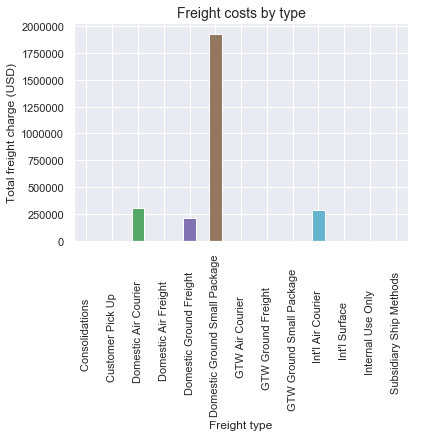

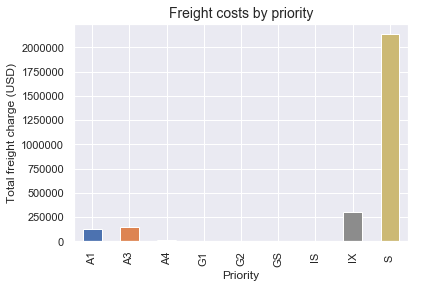

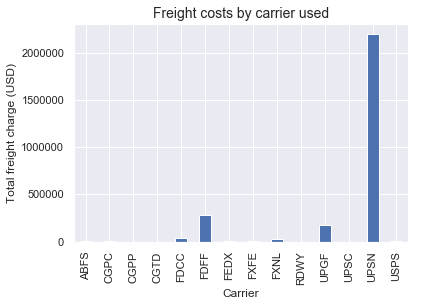

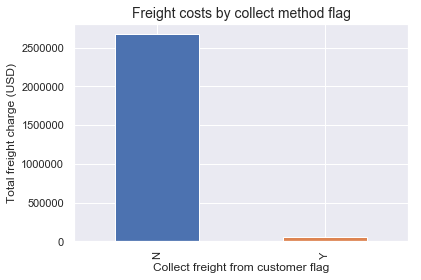

In [4]:
# EDA bar plots
plot1 = df1.groupby(['FREIGHT_TYPE'])['TOTALCHARGE'].sum()
plot1.plot(kind='bar')
plt.xlabel('Freight type')
plt.ylabel('Total freight charge (USD)')
plt.title('Freight costs by type',fontsize=14)
plt.xticks(rotation=90)
plt.show()

plot2 = df1.groupby(['PRIORITY_CODE'])['TOTALCHARGE'].sum()
plot2.plot(kind='bar')
plt.xlabel('Priority')
plt.ylabel('Total freight charge (USD)')
plt.title('Freight costs by priority',fontsize=14)
plt.show()

plot3 = df1.groupby(['CARRIER_CODE'])['TOTALCHARGE'].sum()
plot3 = pd.DataFrame(plot3)
plot3 = plot3[plot3['TOTALCHARGE'] > 0]
plot3.plot(kind='bar',legend=None)
plt.xlabel('Carrier')
plt.ylabel('Total freight charge (USD)')
plt.title('Freight costs by carrier used',fontsize=14)
plt.show()

plot4 = df1.groupby(['COLLECT_METHOD'])['TOTALCHARGE'].sum()
plot4.plot(kind='bar')
plt.xlabel('Collect freight from customer flag')
plt.ylabel('Total freight charge (USD)')
plt.title('Freight costs by collect method flag',fontsize=14)
plt.show()

#### Distribution of Freight Cost Data

By plotting a frequency histogram of our freight charge variable, we can see that the distribution of our freight cost data isn't exactly normal.  It is a multimodal distribution that appears to be right skewed, likely due to some outliers on the higher side of the scale.  This type of distribution is reasonable for the data that we're working with (we would expect there to be some high outliers for some larger/non-standard shipments), but it does limit any statistical analysis and testing to more non-parametric methods.

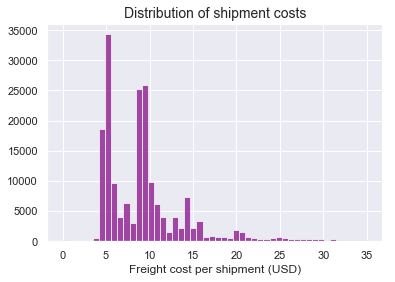

In [5]:
# Frequency hist
df2 = df1[df1['TOTALCHARGE'] > 0]
plt.hist(x=df2['TOTALCHARGE'],bins=50,range=(0,35),color='purple',alpha=0.7)
plt.xlabel('Freight cost per shipment (USD)')
plt.title('Distribution of shipment costs',fontsize=14)
plt.show()

### Machine Learning Models

From our research so far, we've learned that our year's worth of freight data represents about 2.73 million USD in cost, and that the average charge for most cost-bearing shipments is somewhere around 5 to 10 dollars per shipment.  We've learned that most of our cost-bearing shipments are domestic, small package, standard priority, and through UPS.  We can likely tag the vast majority of our cost-bearing shipments by collect method flags of "N."

We saw that there looks to be some correlation between number of units shipped and total freight costs over time, but it's unclear exactly what correlation there is, what anomalies may be affecting this correlation, and/or what other variables need to be added to the relationship to get a better sense of the trends we might be seeing.  Why do two of our three peaks in freight cost seem to be related to increases in volume, but not the other?  Why did our increased volume in November not lead to the increase in freight costs that we would've expected?  What types of products are associated with the largest costs, and why?  What types of shipments tend to have no cost associated with them at all?

All of these questions converge in the direction of a classic regression problem.  However, in the following sections, we'll be testing a wide range of models in order to look for the best fit (pun intended!) and performance.  In addition to the standard suite of popular regression models (linear, ridge, LASSO), we'll also be modeling with decision trees, random forests, and gradient boosted machine methods.

#### Preprocessing  

The dataset is first preprocessed for modeling by 1.) scaling continuous variables to a uniform range, and 2.) converting categorical variables to binary via one-hot encoding.  Input and target variables are split into training and test sets at 80% and 20%, respectively, using a consistent seed of 24 for all following models.

In [6]:
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn import metrics

# New DF for modeling
df2 = df1

# Scale continuous
scaler = pp.MinMaxScaler()
scaled1 = scaler.fit_transform(df2.iloc[:,10:51])
df2.iloc[:,10:51] = scaled1
scaled2 = scaler.fit_transform(df2.iloc[:,0:3])
df2.iloc[:,0:3] = scaled2

# Generate dummy variables
df2 = pd.DataFrame(pd.get_dummies(df2))

# Test/train split at 80% train, 20% test
X = df2.drop('TOTALCHARGE',axis=1).values
y = df2['TOTALCHARGE'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=24)

#### Basic Linear Regression  
The goal of our first model is to do a test run on all possible variables to get a better sense of which features contribute the most significant correlation coefficients.

In [7]:
from sklearn.linear_model import LinearRegression

# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

# Evaluate performance
print('R2 =',linreg.score(X_test, y_test),', therefore 30% of the variance in the observed data can be explained by the model.')
print('MAE (Mean Absolute Error) =',metrics.mean_absolute_error(y_test, y_pred))
print('MSE (Mean Squared Error) = ',metrics.mean_squared_error(y_test, y_pred))
print('RMSE (Root Mean Squared Error) =',np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('')

# Evaluate coefficients
print("Coefficient mean:",np.mean(linreg.coef_))
print("Coefficient median:",np.median(linreg.coef_))
print("Coefficient minimum:",np.min(linreg.coef_))
print("Coefficient maxmimum:",np.max(linreg.coef_))
print('')
print('Model Coefficients:')
cols = df2.drop('TOTALCHARGE',axis=1)
for idx, col_name in enumerate(cols.columns):
    print('The coefficient for {} is {}'.format(col_name, linreg.coef_[0][idx]))

R2 = 0.3068850887815435 , therefore 30% of the variance in the observed data can be explained by the model.
MAE (Mean Absolute Error) = 4.6348538309497656
MSE (Mean Squared Error) =  629.976898302008
RMSE (Root Mean Squared Error) = 25.099340594964

Coefficient mean: -1.6653920020103947
Coefficient median: -3.067527930202346
Coefficient minimum: -878.1795605340708
Coefficient maxmimum: 1569.9403603764401

Model Coefficients:
The coefficient for CJDAT1 is -1.0558846661797516
The coefficient for IHINDT is 1.4296936520727104
The coefficient for IHAEDT is -323.3435411143475
The coefficient for INVOICENO is -5.8648002010386335e-09
The coefficient for MARKET_OUTLET is 6.124462834352164
The coefficient for BOOK_WEIGHT Agency is 159.4524608602389
The coefficient for BOOK_WEIGHT Education is 188.5073025391366
The coefficient for BOOK_WEIGHT Reference is 101.09634296421888
The coefficient for BOOK_WEIGHT Test Prep is -78.50114883383881
The coefficient for BOOK_WEIGHT Trade is 286.5998631700031
T

There's quite a bit of interesting information in this initial model.  We start with an R2 of 0.30 and an RMSE of 25, the latter of which we'll be aiming to improve in future models.  
Our mean coefficient is a little bit higher than our median, which reflects slightly more coefficients on the positive side.  This implies more positive correlations (e.g. variables in which as those variables increase, freight cost also increase).  
Our model coefficients highlight the relative importance of the variables fed into the model.  However, this model ends up being quite a bit too many coefficients to reasonably interpret by eyeballing them, so we will next need to consider some more in-depth regression models that assist with variable selection and add regularization to the mix.

#### LASSO Regression  

The goal of the LASSO model will primarily be assisting with variable selection.  By shrinking our less signficant coefficients to zero, we can more easily visualize and determine which variables are most signficant for our model (without sifting through the full list of them).

In [12]:
from sklearn.linear_model import Lasso

# Reuse train/test split from previous linear model @ 80/20 train/test

# Train and fit the model
lasso = Lasso(alpha = .001, normalize = True, random_state = 24)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
print('R2 =',lasso.score(X_test, y_test))
print('MAE =',metrics.mean_absolute_error(y_test, lasso_pred))
print('MSE = ',metrics.mean_squared_error(y_test, lasso_pred))
print('RMSE =',np.sqrt(metrics.mean_squared_error(y_test, lasso_pred)))

# Perform feature selection
print("")
lasso_coef = pd.Series(lasso.coef_, index = df2.drop('TOTALCHARGE',axis=1).columns)
print('Significant features:')
print(lasso_coef[lasso_coef > 0])

R2 = 0.2852131191001017
MAE = 4.094754973667385
MSE =  649.6747002379221
RMSE = 25.48871711636194

Significant features:
TOTAL_CARTONS Test Prep                        169.496356
TOTAL_LOOSE Test Prep                           99.050887
TOTAL_PALLETS Trade                             44.665863
TOTAL_UNITS Test Prep                          226.493152
TOTAL UNITS Total                              713.102407
COLLECT_METHOD_N                                 3.898855
CARRIER_CODE_FEDX                               27.476570
CARRIER_CODE_UPSN                                1.924018
SHIP_METHOD_FEDEX FREIGHT PPD                  275.742278
SHIP_METHOD_FEDEX National Pre-Paid            531.027921
SHIP_METHOD_FedEx Int'l Priority Prepaid        82.817115
SHIP_METHOD_FedEx International Economy PP       9.711912
SHIP_METHOD_Fedex Ground Bill Recipient         28.343932
SHIP_METHOD_UPS 1-Day Air                       20.005259
SHIP_METHOD_UPS 2-Day Air                       13.113094
SHIP_METH

From our lasso model, we can see that our unit volumes, collect flag, carrier code, ship methods, and a handful of ship to countries are significant variables for our model.  Total units has the highest coefficient of the group, with the next highest being some of our ship methods.  This tracks with our previous analysis, in which total units generally correlates positively with freight costs (in other words, the higher the number of units in an order, the higher the total freight cost).
However, this method has a slightly lower R2 and slightly higher RMSE than our basic linear regression, which eliminates the need for it as our final regression model.

#### Ridge Regression

The goal of the Ridge model will be to mitigate any possible multicolinearity and perform regularization, since our current dataset has a large number of parameters due to the one-hot encoding.

In [17]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha = 0.1, normalize = True, random_state = 24)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

print('R2 =',ridge.score(X_test, y_test))
print('MAE =',metrics.mean_absolute_error(y_test, ridge_pred))
print('MSE = ',metrics.mean_squared_error(y_test, ridge_pred))
print('RMSE =',np.sqrt(metrics.mean_squared_error(y_test, ridge_pred)))

R2 = 0.3054438044283987
MAE = 4.345659164456973
MSE =  631.2868915393043
RMSE = 25.125423211148192


Although our Ridge model performs better than the LASSO model, it still doesn't manage to improve upon the basic OLS regression we used in the first model.

#### Finalized Linear Regression  

For our final model, we'll be reducing our features to some of the high level categories identified as significant in our LASSO model, and then performing a stronger preprocessing on our dataset to feed into the end model.  
  
Given the coefficients found in our LASSO model, we can feed the more significant groups into the model: those variable groups being total units, total cartons, total weight, ship method, freight type, carrier code, and collect flag.  We'll also keep ship month in order to preserve the necessary calendarization of the model.

In [43]:
# Preprocessing
df3 = df1
df3 = df3.drop(df3.iloc[:,11:46],axis=1)
df3 = df3.drop(['CJDAT1','IHINDT','INVOICENO','MARKET_OUTLET'],axis=1)

# Scale continuous
scaler = pp.MinMaxScaler()
scaled1 = scaler.fit_transform(df3.iloc[:,7:12])
df3.iloc[:,7:12] = scaled1
df3 = df3[['CARRIER_CODE','FREIGHT_TYPE','SHIP_METHOD','COLLECT_METHOD','TOTAL UNITS Total','TOTAL CARTONS Total','CARTON_WEIGHT Total','SHIP_MONTH','TOTALCHARGE']]
#df3 = df3[['SHIP_METHOD','IHAEDT','SHIP_MONTH','TOTAL UNITS Total','TOTAL CARTONS Total','CARTON_WEIGHT Total','TOTALCHARGE']]

# Generate dummy variables
df3 = pd.DataFrame(pd.get_dummies(df3))

# Test/train split at 80% train, 20% test
X2 = df3.drop('TOTALCHARGE',axis=1).values
y2 = df3['TOTALCHARGE'].values.reshape(-1,1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state=24)

# Fit & predict the model
linreg2 = LinearRegression()
linreg2.fit(X2_train, y2_train)
y2_pred = linreg2.predict(X2_test)

print('R2 =',linreg2.score(X2_test, y2_test),', which represents the % of the variance in the observed data can be explained by the model.')
print('MAE =',metrics.mean_absolute_error(y2_test, y2_pred))
print('MSE = ',metrics.mean_squared_error(y2_test, y2_pred))
print('RMSE =',np.sqrt(metrics.mean_squared_error(y2_test, y2_pred)))

R2 = 0.27714472094812304 , which represents the % of the variance in the observed data can be explained by the model.
MAE = 4.242642942531871
MSE =  657.0081226759328
RMSE = 25.632169683347776


Since narrowing down our features does not appear to improve the model all that much, it's possible that the relationship between our input variables and the target is somewhat nonlinear.  Therefore, tree models are an advantageous alternative.

#### Decision Tree for Regression

A decision tree for regression will perform similar to the commonly known decision tree for classification, except that our target values will ultimately be displayed as leaf nodes of a tree rather than points along a regression line.  This will help capture any non-linear trends identified by the dataset.

In [44]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

dt = DecisionTreeRegressor(min_samples_leaf=0.001, random_state=24)

dt.fit(X2_train, y2_train)
y2_pred_test = dt.predict(X2_test)
y2_pred_train = dt.predict(X2_train)
MSE_test = MSE(y2_test, y2_pred_test)
RMSE_test = MSE_test**(1/2)
MSE_train = MSE(y2_train, y2_pred_train)
RMSE_train = MSE_train**(1/2)

print('R2 score =',r2_score(y2_test,y2_pred_test))
print('MSE for test set =',MSE_test)
print('RMSE for test set =',RMSE_test)
print('MSE for training set =',MSE_train)
print('RMSE for training set =',RMSE_train)

# Compute MSE/RMSE using cross-validation
from sklearn.model_selection import cross_val_score 
MSE_CV_scores = - cross_val_score(dt, X2_train, y2_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 
RMSE_CV = (MSE_CV_scores.mean())**(1/2)
print('CV RMSE: {:.2f}'.format(RMSE_CV))

R2 score = 0.3054749603300321
MSE for test set = 631.2585737265475
RMSE for test set = 25.12485967575834
MSE for training set = 731.0392759432987
RMSE for training set = 27.037737996054673
CV RMSE: 27.23


Although the decision tree regressor performs somewhat similarly to our previous OLS regression models (if slightly underfit), it does offer feature importance for each variable, which gives a slightly different snapshot of which variables hold the most importance for the model.

In [46]:
X2cols = df3.drop('TOTALCHARGE',axis=1).columns
dt_df = pd.DataFrame(dt.feature_importances_,X2cols,columns=['FI'])
print('Feature importances by variable:')
print(dt_df[dt_df['FI'] > 0].sort_values(by=['FI']))

Feature importances by variable:
                                                       FI
SHIP_MONTH_2018-10                           8.469062e-10
SHIP_METHOD_UPS Ground Collect Acct# Req.    4.702892e-08
SHIP_MONTH_2018-06                           5.234062e-08
SHIP_MONTH_2018-09                           1.696714e-07
FREIGHT_TYPE_Domestic Air Courier            1.739434e-07
SHIP_MONTH_2018-11                           2.018735e-07
CARRIER_CODE_UPSC                            5.820258e-07
SHIP_MONTH_2018-05                           1.203295e-06
SHIP_METHOD_FedEx 2-Day Third Party Bill     1.282224e-06
SHIP_METHOD_FedEx 1-Day Std. 3rd Party       1.971143e-06
FREIGHT_TYPE_Domestic Ground Freight         2.434330e-06
CARRIER_CODE_FDFF                            2.833406e-06
CARRIER_CODE_FDCC                            1.324753e-05
SHIP_MONTH_2018-08                           1.523548e-05
FREIGHT_TYPE_Int'l Air Courier               1.668213e-05
SHIP_MONTH_2019-01                     

The ranking of features varies a bit from our OLS regression models, but the general list of them is actually quite similar.  The ship month variable holds a bit more importance than in the previous models, which demonstrates that the tree model handles that seasonal variable a bit better.
  
Although our R2 score for this model is a good one, our RMSE does not experience much improvement.  The next step in our process will be to combine regression with decision trees in a random forest model.

#### Random Forest

Our first ensemble model will be a Random Forest.  Since Random Forest models combine bagging (bootstrap aggregation), regression methods, and multiple decision trees, they may boost performance for the linear/nonlinear problem at hand.

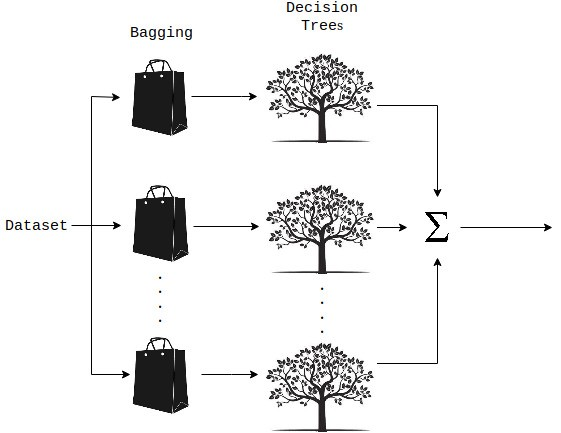

In [45]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Instantiate regressor
rf = RandomForestRegressor(n_estimators=25,random_state=24) 
rf.fit(X2_train,np.ravel(y2_train)) 
y3_pred_test = rf.predict(X2_test)
mse_test = MSE(y2_test, y3_pred_test)
rmse_test = MSE(y2_test, y3_pred_test)**(1/2)

# Print rmse_test
print('R2 score =',r2_score(y2_test,y3_pred_test))
print('MSE for test set =',mse_test)
print('RMSE for test set = {:.2f}'.format(rmse_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


R2 score = 0.519900945619372
MSE for test set = 436.3653245098176
RMSE for test set = 20.89


We can see from our R2 and RMSE scores that the Random Forest performs better than any of our previous models; therefore, our assumption that there are both linear and nonlinear aspects to this model may hold some water.  This performance also raises the possibility that a Gradient Boosted Machine could also provide value, as we'll demonstrate in the next model.

#### Gradient Boosting

Our final model will be a Gradient Boosting Regressor, which is a type of inductively generated tree ensemble model. At each step, a new tree is trained against the negative gradient of the loss function, which is analogous to (or identical to, in the case of least-squares error) the residual error.

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate regressor
gbt = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=24)
gbt.fit(X2_train, np.ravel(y2_train))

y4_pred_test = gbt.predict(X2_test)
mse_test = MSE(y2_test, y4_pred_test)
rmse_test = MSE(y2_test, y4_pred_test)**(1/2)

# Print rmse_test
print('R2 score =',r2_score(y2_test,y4_pred_test))
print('MSE for test set =',mse_test)
print('RMSE for test set = {:.2f}'.format(rmse_test))

R2 score = 0.46625387728362044
MSE for test set = 485.12551299536085
RMSE for test set = 22.03


Although the Gradient Boosting Regressor model does add more value than our linear regressions, it does not surpass the Random Forest (with our lowest RMSE yet at 20.89) as the optimal model for freight prediction.

#### Forecast variance on high performing models

In [59]:
print('Freight value (USD) of test set =',np.asscalar(sum(y2_test)))
print('Random Forest forecast variance =',np.asscalar((sum(y3_pred_test)-sum(y2_test))/sum(y2_test)))
print('Gradient Boosting forecast variance =',np.asscalar((sum(y4_pred_test)-sum(y2_test))/sum(y2_test)))

Freight value (USD) of test set = 541640.9860000338
Random Forest forecast variance = 0.030848298318179194
Gradient Boosting forecast variance = 0.02560442943680711


### Conclusions and Recommendations

Both our EDA and ML modeling provided insight into the variables that influence and correlate with our overall freight costs--total units shipped, collect shipment flags, carrier, priority, ship method, and freight type all play a part in how much a shipment will cost.  Total units shipped appears to have the strongest relationship, especially on a seasonal/calendarized basis, but units alone cannot be used as a predictor.

We also saw that the relationship between our dataset and our target variable is not entirely linear.  For this reason, ensemble methods like Random Forests and Gradient Boosting are the most effective predictors of cost.  The most optimal of these two models, in its current state, yields a root mean squared error (RMSE) of ~20, which tells us that the standard deviation of our residuals (i.e. difference between the predicted and observed values) hovers around 20 USD.  This could most certainly be improved upon.

In terms of forecast variance, our Random Forest model varies from actuals by about 3.0%, and the Gradient Boosting model by about 2.5%, which is certainly an improvement over current forecasting methods--but could also be lessened even further through more fine tuning.

Going forward, I would recommend forecasting with both Random Forest and Gradient Boosted models, while continuing to fine tune both the feature selection and hyperparameters of each.  

I would also recommend adding a few higher level variables to the initial dataset:   
+ Geographic region (continent) as a substitute for ship-to country
+ Higher level market outlet groupings as a substitute for market outlet code.  
+ A better shipment-level product identifier than global business, which could be derived from more unsupervised methods such as k-means clustering.  
  
These additional features would give a better idea of the customer side of the equation, as well as a richer dataset overall with which to model.